In [9]:
import pandas as pd
import seaborn as sns
import sys
import string
print('Original sys.path:', sys.path)

# Append a new directory to sys.path
sys.path.append('C:/Users/joepa/OneDrive/Desktop/computerScienceYear4/Data Mining/summary_eval/summary_eval')

# Print the updated sys.path
print('Updated sys.path:', sys.path)
from summary_eval.data import summary_df, prompts_df
from summary_eval.settings import TRAIN_SIZE
from summary_eval.testing import cross_validate

merged_df = pd.merge(summary_df, prompts_df, on='prompt_id')

Original sys.path: ['c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\notebooks', 'C:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval', 'C:\\Users\\joepa\\anaconda3\\python39.zip', 'C:\\Users\\joepa\\anaconda3\\DLLs', 'C:\\Users\\joepa\\anaconda3\\lib', 'C:\\Users\\joepa\\anaconda3', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv', '', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv\\lib\\site-packages', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv\\lib\\site-packages\\win32', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\joepa\\OneDrive\\Desktop\\computerScienceYear4\\Data Mining\\summary_eval\\venv\\lib\\site-packages\\Pythonwin', 'C:/Users/joepa/OneDrive/Desktop/computerScienceYear4/Data M

In [10]:
#PREPROCESSING
from typing import List
import re
from autocorrect import Speller
import nltk
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

def pre_process_whitespace(text: str) -> str:
    # Replace all whitespace with a single space
    text = ' '.join(text.split())
    
    # Remove leading and trailing whitespace
    text = text.strip()
    return text

merged_df["text"] = merged_df["text"].apply(lambda x: pre_process_whitespace(x))

nltk.download('punkt')

def correct_spelling(text: str) -> str:
    spell = Speller(lang='en')
    corrected_text = []
    for word in nltk.word_tokenize(text):
        corrected_text.append(spell(word))

    return ' '.join(corrected_text)

# Apply correct_spelling function to 'text' column in merged_df
#merged_df['text'] = merged_df['text'].apply(correct_spelling)

print(merged_df)

features_df = pd.DataFrame()

        student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0020ae56ffbf    ebad26   
2     004e978e639e    3b9047   
3     005ab0199905    3b9047   
4     0070c9e7af47    814d6b   
...            ...       ...   
7160  ff7c7e70df07    ebad26   
7161  ffc34d056498    3b9047   
7162  ffd1576d2e1b    3b9047   
7163  ffe4a98093b2    39c16e   
7164  fffbccfd8a08    ebad26   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     They would rub it up with soda to make the sme... -0.548304  0.506755   
2     In Egypt, there were many occupations and soci...  3.128928  4.231226   
3     The highest class was Pharaohs these people we... -0.210614 -0.471415   
4     The Third Wave developed rapidly because the s...  3.272894  3.219757   
...                                                 ...       ...       ...   
7160  They used all sorts of chemical concoctions to...  0.205

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
def count_specific_punctuation(text):
    punctuation_counts = {
        'num_commas': text.count(','),
        'num_quotation_marks': text.count('"'),
        'num_brackets': text.count('(') + text.count(')'),
        'num_full_stops': text.count('.')
    }
    return pd.Series(punctuation_counts)

# Apply the function to each text in the DataFrame
punctuation_counts_df = summary_df['text'].apply(count_specific_punctuation)

# Rename the columns to avoid conflicts
punctuation_counts_df.columns = [f'{col}_punctuation' for col in punctuation_counts_df.columns]

# Concatenate the original DataFrame with the new punctuation counts DataFrame
features_df = punctuation_counts_df
print(features_df)

      num_commas_punctuation  num_quotation_marks_punctuation  \
0                          0                                0   
1                          0                                0   
2                         16                                4   
3                          0                                0   
4                          5                                8   
...                      ...                              ...   
7160                       6                                2   
7161                       3                                0   
7162                       0                                0   
7163                       1                                0   
7164                       0                                4   

      num_brackets_punctuation  num_full_stops_punctuation  
0                            0                           3  
1                            0                           2  
2                            0      

In [12]:
#FEATURE CREATION
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from tqdm import tqdm
tqdm.pandas()

features_df["num_words"] = summary_df["text"].apply(lambda x: len(word_tokenize(x)))

def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

features_df['punctuation_count'] = merged_df['text'].apply(count_punctuation)

def count_words(text):
    return len(text.split()) 

features_df['response_length'] = merged_df['text'].apply(count_words)

def find_similar_words(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

def count_repeated_words(response, prompt):
    repeated_words = set()
    prompt_words = set(prompt.split())
    for word in response.split():
        if word in prompt_words:
            repeated_words.add(word)
        else:
            synonyms = find_similar_words(word)
            if synonyms.intersection(prompt_words):
                repeated_words.add(word)
    return len(repeated_words)

# Calculate the number of repeated words for each response text
features_df['repeated_words_prompt_text'] = merged_df.apply(lambda row: count_repeated_words(row['text'], row['prompt_text']), axis=1)

features_df['repeated_words_prompt_question'] = merged_df.apply(lambda row: count_repeated_words(row['text'], row['prompt_question']), axis=1)

from nltk.corpus import stopwords

nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to count the number of stopwords in a text
def count_stopwords(text):
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stop_words)
    return stopwords_count

# Calculate the number of stopwords for each response
features_df['stopwords_count'] = merged_df['text'].apply(count_stopwords)

from collections import Counter
def calculate_repetition(text):
    # Tokenize the text into words
    words = text.lower().split()
    # Count the frequency of each word
    word_counts = Counter(words)
    # Calculate repetition metric (e.g., total number of repeated words)
    repetition = sum(count for word, count in word_counts.items() if count > 1)
    return repetition

features_df['repetition'] = merged_df['text'].apply(calculate_repetition)

from nltk.tokenize import word_tokenize

mean_word_lengths = []

# Iterate over each text in the 'text' column
for text in summary_df['text']:
    # Tokenize the text into words
    words = word_tokenize(text)
    # Calculate the mean word length for the text and append it to the mean_word_lengths list
    mean_word_lengths.append(sum(len(word) for word in words) / len(words) if words else 0)

# Add the mean word lengths as a new column in the DataFrame
features_df['mean word length'] = mean_word_lengths

def is_any_alpha(input_string):
    return any(char.isalpha() for char in input_string)

def extract_proper_nouns(text):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    proper_nouns = set()
    for tagged_word in tagged_words:
        if isinstance(tagged_word, tuple) and tagged_word[1] == 'NNP':
            if is_any_alpha(tagged_word[0]) is True:
                proper_nouns.add(tagged_word[0])
    return list(proper_nouns)

def prop_noun_intersection(prompt_prop_nouns, summary):
    prompt_proper_nouns = set(prompt_prop_nouns)
    summary_proper_nouns = set(extract_proper_nouns(summary))
    return len(prompt_proper_nouns.intersection(summary_proper_nouns))/len(prompt_proper_nouns)

prompt_prop_nouns = {}
for i, prompt in prompts_df.iterrows():
    prompt_prop_nouns[prompt["prompt_id"]] = extract_proper_nouns(prompt["prompt_text"])

features_df["proper_noun_intersection"] = merged_df.progress_apply(lambda row: prop_noun_intersection(prompt_prop_nouns[row["prompt_id"]], row["text"]), axis=1)

def split_quotations(text: str) -> (str, List[str]):
    quotations = re.findall('"([^"]*)"', text)
    no_quote_text = text
    for quotation in quotations:
        no_quote_text = no_quote_text.replace(f'"{quotation}"', "")
    return no_quote_text, quotations

def count_quotations(text: str) -> int:
    return len(re.findall('"([^"]*)"', text))

features_df["quoteCount"] = summary_df["text"].apply(count_quotations)

def avg_quote_length(text: str) -> float:
    no_quote_text, quotations = split_quotations(text)
    if len(quotations) == 0:
        return 0
    return sum(len(q) for q in quotations) / len(quotations)

features_df["avgQuoteLength"] = summary_df["text"].apply(avg_quote_length)

from textblob import TextBlob

def get_polarity(text: str) -> float:
    blob = TextBlob(text)
    return blob.sentiment.polarity

features_df["polarity"] = summary_df["text"].progress_apply(get_polarity)

def get_subjectivity(text: str) -> float:
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

features_df["subjectivity"] = summary_df["text"].progress_apply(get_subjectivity)

def textblob_pos_filter(text: str, pos_tag: str) -> List[str]:
    blob = TextBlob(text)
    return [word for word, pos in blob.tags if pos.startswith(pos_tag)]

def count_duplicates(words: List[str]) -> dict:
    word_counts = {}
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    return word_counts

def num_adjectives_repeated(text: str) -> int:
    adjectives = textblob_pos_filter(text, "JJ")
    return len([word for word, count in count_duplicates(adjectives).items() if count >= 2])

features_df["numAdjectivesRepeated2p"] = summary_df["text"].progress_apply(num_adjectives_repeated)

def prop_adjectives_repeated_text_normalised(text: str) -> float:
    adjectives = textblob_pos_filter(text, "JJ")
    if len(adjectives) == 0:
        return None
    return len([word for word, count in count_duplicates(adjectives).items() if count >= 2]) / len(text)

features_df["propAdjectivesRepeated2pTextNormalised"] = summary_df["text"].progress_apply(prop_adjectives_repeated_text_normalised)

import textstat

def felsch_reading_ease(text: str) -> float:
    return textstat.flesch_reading_ease(text)

features_df["fleschReadingEase"] = summary_df["text"].progress_apply(felsch_reading_ease)

features_df["num_sentences"] = summary_df["text"].apply(lambda x: len(nltk.sent_tokenize(x)))
features_df["words_per_sentence"] = features_df["num_words"] / features_df["num_sentences"]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-

Adding extra features (and embeddings?)

In [13]:
#MODELS
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

X = features_df
y = merged_df[["content", "wording"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=42)

model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))
results_df = cross_validate(model, X_train, y_train)

2024-03-17 14:42:35,586 - INFO - Using 10x10 cross validation


  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "max_iter": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "l2_regularisation": [0, 1, 10],
}

scores = {}  # parameter combination -> mean columnwise RMSE

for learning_rate in param_grid["learning_rate"]:
    for max_iter in param_grid["max_iter"]:
        for max_depth in param_grid["max_depth"]:
            for l2_regularisation in param_grid["l2_regularisation"]:
                model = MultiOutputRegressor(
                    HistGradientBoostingRegressor(
                        learning_rate=learning_rate,
                        max_iter=max_iter,
                        max_depth=max_depth,
                        l2_regularization=l2_regularisation,
                        random_state=0,
                    )
                )
                results_df = cross_validate(model, X_train, y_train, n_folds=5, n_runs=1)
                scores[(learning_rate, max_iter, max_depth, l2_regularisation)] = results_df["rmse"]["mean_columnwise"]["mean"]

                print(
                    learning_rate,
                    max_iter,
                    max_depth,
                    l2_regularisation,
                    scores[(learning_rate, max_iter, max_depth, l2_regularisation)],
                )

{k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}



2024-03-17 14:44:24,106 - INFO - Using 1x5 cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:44:28,962 - INFO - Using 1x5 cross validation


0.1 100 None 0 0.5417670460577358


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:44:34,065 - INFO - Using 1x5 cross validation


0.1 100 None 1 0.5414431789020788


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:44:39,097 - INFO - Using 1x5 cross validation


0.1 100 None 10 0.5389974942375992


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:44:41,922 - INFO - Using 1x5 cross validation


0.1 100 5 0 0.5424827245907459


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:44:45,011 - INFO - Using 1x5 cross validation


0.1 100 5 1 0.5418868117528445


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:44:48,113 - INFO - Using 1x5 cross validation


0.1 100 5 10 0.5405201573719871


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:44:52,772 - INFO - Using 1x5 cross validation


0.1 100 10 0 0.5404996483309885


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:44:57,367 - INFO - Using 1x5 cross validation


0.1 100 10 1 0.541023303493578


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:45:02,331 - INFO - Using 1x5 cross validation


0.1 100 10 10 0.5391876198979961


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:45:07,437 - INFO - Using 1x5 cross validation


0.1 100 20 0 0.5418263096776946


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:45:12,194 - INFO - Using 1x5 cross validation


0.1 100 20 1 0.5418297667977001


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:45:17,503 - INFO - Using 1x5 cross validation


0.1 100 20 10 0.5388395411135997


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:45:26,233 - INFO - Using 1x5 cross validation


0.1 200 None 0 0.5472853097122355


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:45:35,843 - INFO - Using 1x5 cross validation


0.1 200 None 1 0.5467036558659556


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:45:44,804 - INFO - Using 1x5 cross validation


0.1 200 None 10 0.5439961767840737


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:45:50,352 - INFO - Using 1x5 cross validation


0.1 200 5 0 0.5420530409949975


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:45:55,339 - INFO - Using 1x5 cross validation


0.1 200 5 1 0.541488054752209


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:46:00,872 - INFO - Using 1x5 cross validation


0.1 200 5 10 0.5390531569395804


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:46:09,314 - INFO - Using 1x5 cross validation


0.1 200 10 0 0.5454756337347402


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:46:17,695 - INFO - Using 1x5 cross validation


0.1 200 10 1 0.5460115421790608


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:46:26,115 - INFO - Using 1x5 cross validation


0.1 200 10 10 0.5427581123767788


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:46:35,816 - INFO - Using 1x5 cross validation


0.1 200 20 0 0.5473570700279242


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:46:44,595 - INFO - Using 1x5 cross validation


0.1 200 20 1 0.5478669252258277


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:46:53,845 - INFO - Using 1x5 cross validation


0.1 200 20 10 0.5437808787065845


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:47:07,007 - INFO - Using 1x5 cross validation


0.1 300 None 0 0.5521418480492005


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:47:20,134 - INFO - Using 1x5 cross validation


0.1 300 None 1 0.5521113034380687


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:47:33,531 - INFO - Using 1x5 cross validation


0.1 300 None 10 0.5484433015157417


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:47:40,663 - INFO - Using 1x5 cross validation


0.1 300 5 0 0.5446815290717688


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:47:48,294 - INFO - Using 1x5 cross validation


0.1 300 5 1 0.5438255220664847


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:47:55,533 - INFO - Using 1x5 cross validation


0.1 300 5 10 0.540660089170483


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:48:07,836 - INFO - Using 1x5 cross validation


0.1 300 10 0 0.5504180360443381


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:48:19,631 - INFO - Using 1x5 cross validation


0.1 300 10 1 0.5501794655707362


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:48:31,903 - INFO - Using 1x5 cross validation


0.1 300 10 10 0.5472469594399574


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:48:45,025 - INFO - Using 1x5 cross validation


0.1 300 20 0 0.553056188070231


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:48:57,537 - INFO - Using 1x5 cross validation


0.1 300 20 1 0.5524223860548414


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:49:11,060 - INFO - Using 1x5 cross validation


0.1 300 20 10 0.5490537843172482


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:49:19,187 - INFO - Using 1x5 cross validation


0.01 100 None 0 0.6629100215422817


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:49:27,478 - INFO - Using 1x5 cross validation


0.01 100 None 1 0.6642397224484525


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:49:34,021 - INFO - Using 1x5 cross validation


0.01 100 None 10 0.6746621615747972


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:49:38,724 - INFO - Using 1x5 cross validation


0.01 100 5 0 0.6699893211463593


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:49:43,229 - INFO - Using 1x5 cross validation


0.01 100 5 1 0.6717741919877973


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:49:47,712 - INFO - Using 1x5 cross validation


0.01 100 5 10 0.6822360110325811


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:49:53,827 - INFO - Using 1x5 cross validation


0.01 100 10 0 0.6629704336972946


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:49:59,978 - INFO - Using 1x5 cross validation


0.01 100 10 1 0.664319599805706


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:50:06,131 - INFO - Using 1x5 cross validation


0.01 100 10 10 0.674682614676885


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:50:12,293 - INFO - Using 1x5 cross validation


0.01 100 20 0 0.6629100215422817


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:50:18,367 - INFO - Using 1x5 cross validation


0.01 100 20 1 0.6642397224484525


  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-17 14:50:24,994 - INFO - Using 1x5 cross validation


0.01 100 20 10 0.6746621615747972


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

best score achieved with lr = 0.1, max_iter = 200, max_depth = 5, l2_reg = 10

2024-03-17 15:03:32,541 - INFO - Using 5x5 cross validation


  0%|          | 0/25 [00:00<?, ?it/s]

Metric        rmse                                 mae            \
Target     content   wording mean_columnwise   content   wording   
mean      0.464597  0.615788        0.540192  0.351559  0.471607   
stdev     0.011745  0.014519        0.013132  0.008442  0.011644   
n_trials        25        25               2        25        25   

Metric                          r2                            
Target   mean_columnwise   content   wording mean_columnwise  
mean            0.411583  0.800837  0.650247        0.725542  
stdev           0.010043  0.010006  0.011689        0.010848  
n_trials               2        25        25               2

0.5401924612719231
0.1 200 5 10 0.5401924612719231


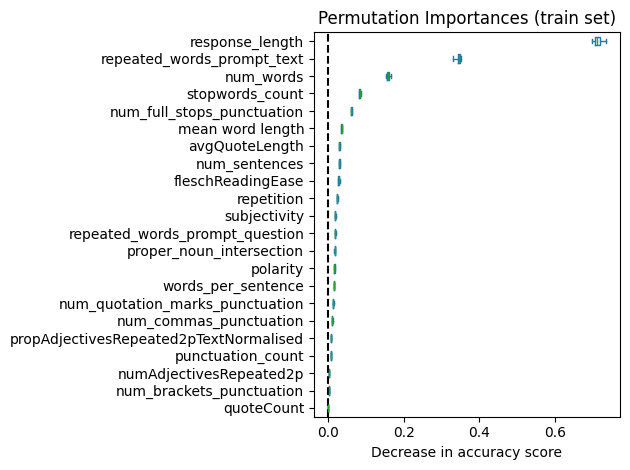

In [21]:
from sklearn.inspection import permutation_importance
model = MultiOutputRegressor(
    HistGradientBoostingRegressor(
        learning_rate=0.1,
        max_iter=200,
        max_depth=5,
        l2_regularization=10,
        random_state=0,
    )
)
scores = {}
results_df = cross_validate(model, X_train, y_train, n_folds=5, n_runs=5)
display(results_df)
print(results_df["rmse"]["mean_columnwise"]["mean"])
scores[(learning_rate, max_iter, max_depth, l2_regularisation)] = results_df["rmse"]["mean_columnwise"]["mean"]

print(
                    0.1,
                    200,
                    5,
                    10,
                    scores[(learning_rate, max_iter, max_depth, l2_regularisation)],
                )

model.fit(X_train, y_train)
result = permutation_importance(
    model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


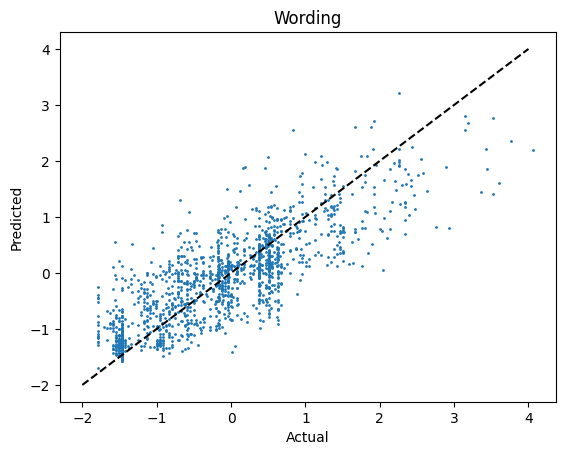

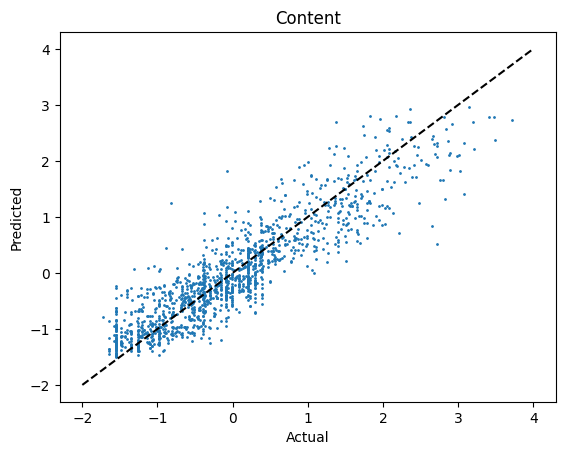

In [ ]:
import matplotlib.pyplot as plt
y_test_pred = model.predict(X_test)

# plot predicted vs actual for wording, then content
plt.scatter(y_test["wording"], y_test_pred[:, 1], s=1)
plt.plot([-2, 4], [-2, 4], color="black", linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Wording")
plt.show()

plt.scatter(y_test["content"], y_test_pred[:, 0], s=1)
plt.plot([-2, 4], [-2, 4], color="black", linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Content")
plt.show()

2024-03-16 17:51:16,955 - INFO - Using 5x5 cross validation


  0%|          | 0/25 [00:00<?, ?it/s]

Metric        rmse                                 mae            \
Target     content   wording mean_columnwise   content   wording   
mean      0.471062  0.621285        0.546173  0.355612  0.474933   
stdev     0.011776   0.01617        0.013973  0.008564  0.012358   
n_trials        25        25               2        25        25   

Metric                          r2                            
Target   mean_columnwise   content   wording mean_columnwise  
mean            0.415272  0.795298  0.644006        0.719652  
stdev           0.010461   0.00932  0.012154        0.010737  
n_trials               2        25        25               2

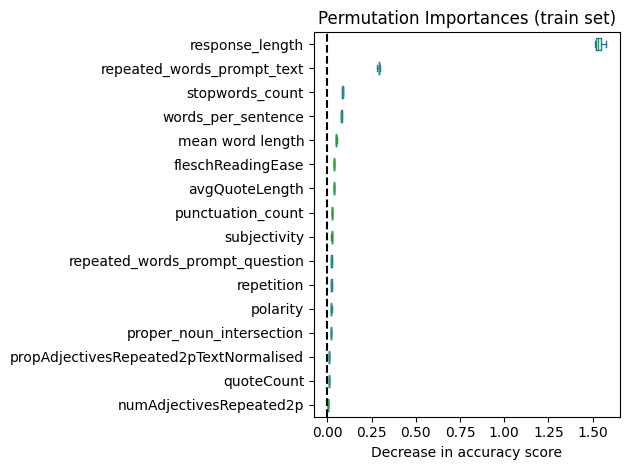

In [ ]:
X_train_ss = X_train.drop(columns=["num_words", "num_sentences"])

model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))

results_df = cross_validate(model, X_train_ss, y_train, n_folds=5, n_runs=5)
display(results_df)

model.fit(X_train_ss, y_train)
result = permutation_importance(
    model, X_train_ss, y_train, n_repeats=10, random_state=42, n_jobs=1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train_ss.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

2024-03-16 17:51:56,849 - INFO - Using 5x5 cross validation


  0%|          | 0/25 [00:00<?, ?it/s]

Metric        rmse                                 mae            \
Target     content   wording mean_columnwise   content   wording   
mean      0.544545  0.840285        0.692415  0.410144  0.654037   
stdev     0.016405  0.020287        0.018346  0.010866  0.015468   
n_trials        25        25               2        25        25   

Metric                          r2                            
Target   mean_columnwise   content   wording mean_columnwise  
mean            0.532091  0.726229   0.34851         0.53737  
stdev           0.013167  0.017901  0.028575        0.023238  
n_trials               2        25        25               2

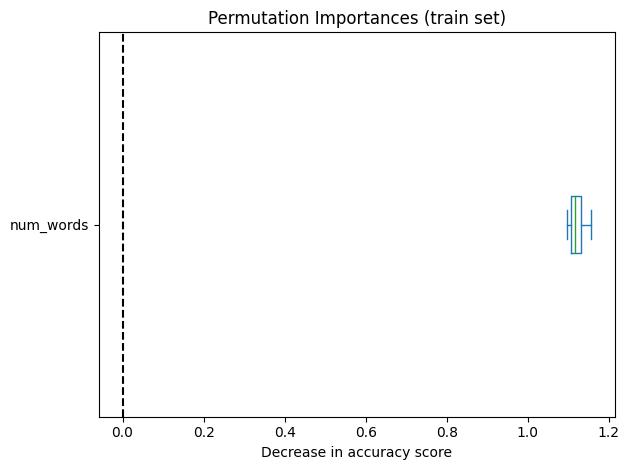

In [ ]:
X_train_nw = X_train[["num_words"]]

model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0))

results_df = cross_validate(model, X_train_nw, y_train, n_folds=5, n_runs=5)
display(results_df)

model.fit(X_train_nw, y_train)
result = permutation_importance(
    model, X_train_nw, y_train, n_repeats=10, random_state=42, n_jobs=1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train_nw.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()